# Probabilistic Surrogate Models

This notebook was adapted from https://github.com/algorithmsbooks/algforopt-notebooks

In [3]:
using Plots
using Distributions
using Optim
using Parameters

import LinearAlgebra: norm, I, diag

In [4]:
const Dset = Vector{Vector{Float64}}

Vector{Vector{Float64}} (alias for Array{Array{Float64, 1}, 1})

In [5]:
@with_kw struct GaussianProcess
    m::Function = x -> 0.0
    k::Function = (x,x′)->exp(-(norm(x-x′))^2)
    X::Vector{Vector{Float64}} = Vector{Float64}[]
    y::Vector{Float64} = Float64[]
    ν::Float64 = 0.0 # variance when sampling f
end

GaussianProcess

In [6]:
μ(X::Dset, m::Function) = [m(x) for x in X]
Σ(X::Dset, k::Function) = [k(x,x′) for x in X, x′ in X]
K(X::Dset, X′::Dset, k::Function) = [k(x,x′) for x in X, x′ in X′]

K (generic function with 1 method)

In [7]:
mvnrand(μ::Vector{Float64}, Σ::Matrix{Float64}, inflation=1e-6) = rand(MvNormal(μ, Σ + inflation*I));
Base.rand(GP::GaussianProcess, X::Dset) = mvnrand(μ(X, GP.m), Σ(X, GP.k))

$\begin{aligned} \hat{\mathbf{y}} \mid \mathbf{y}, v & \sim \mathcal{N}\left(\boldsymbol{\mu}^*, \boldsymbol{\Sigma}^*\right) \\ \boldsymbol{\mu}^* & =\mathbf{m}\left(X^*\right)+\mathbf{K}\left(X^*, X\right)(\mathbf{K}(X, X)+v \mathbf{I})^{-1}(\mathbf{y}-\mathbf{m}(X)) \\ \boldsymbol{\Sigma}^* & =\mathbf{K}\left(X^*, X^*\right)-\mathbf{K}\left(X^*, X\right)(\mathbf{K}(X, X)+v \mathbf{I})^{-1} \mathbf{K}\left(X, X^*\right)\end{aligned}$

In [8]:
function predict(GP::GaussianProcess, X_pred::Dset)
    m, k, ν = GP.m, GP.k, GP.ν
    tmp = K(X_pred, GP.X, k) / (K(GP.X, GP.X, k) + ν*I)
    μₚ = μ(X_pred, m) + tmp*(GP.y - μ(GP.X, m))
    S = K(X_pred, X_pred, k) - tmp*K(GP.X, X_pred, k)
    νₚ = diag(S) .+ eps() # eps prevents numerical issues
    return (μₚ, νₚ)
end

predict (generic function with 1 method)

In [9]:
include("gp.jl")

using LinearAlgebra
using LaTeXStrings
using Plots

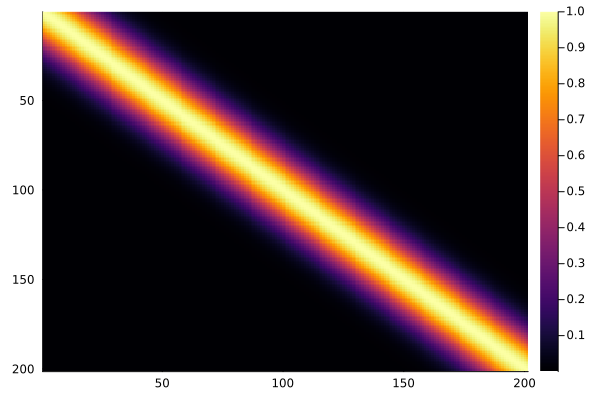

In [11]:
X = [[x] for x in range(0, stop=10, length=201)]
k = (x,x′)->exp(-(norm(x-x′))^2)
Σ(X::Dset, k::Function) = [k(x,x′) for x in X, x′ in X]

heatmap(Σ(X, k), yflip=true)

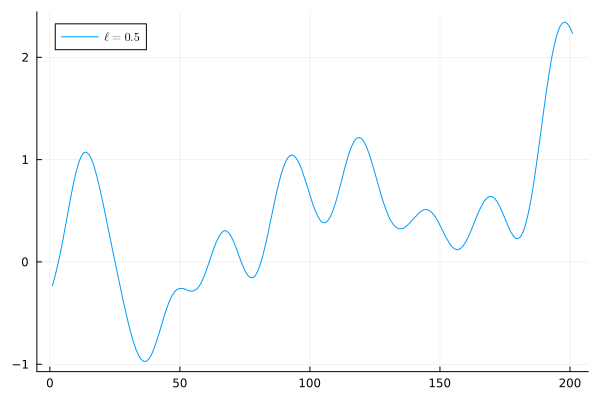

In [12]:
using Random

g = []
Random.seed!(0)
X = [[x] for x in range(0, stop=10, length=201)]

function get_plot(m, l)
	GP = GaussianProcess(m=m, k=(x, x′) -> exp(-(norm(x - x′)^2/(2*l^2))))
	y = rand(GP, X)
	return y
end

labels = [L"\ell = 0.5", L"\ell = 1", L"\ell = 2"]
push!(g, get_plot(x -> 0.0, 0.5))
push!(g, get_plot(x -> 0.0, 1))
push!(g, get_plot(x -> 0.0, 2))

plot(g[1], label=labels[1])


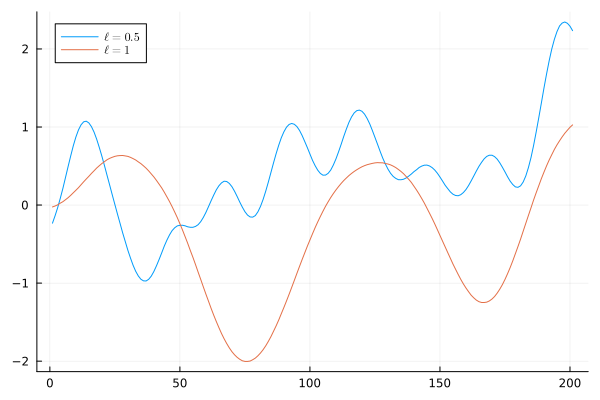

In [13]:
plot!(g[2], label=labels[2])

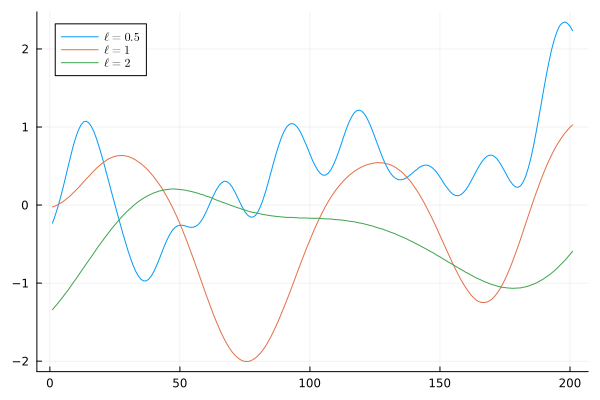

In [14]:
plot!(g[3], label=labels[3])

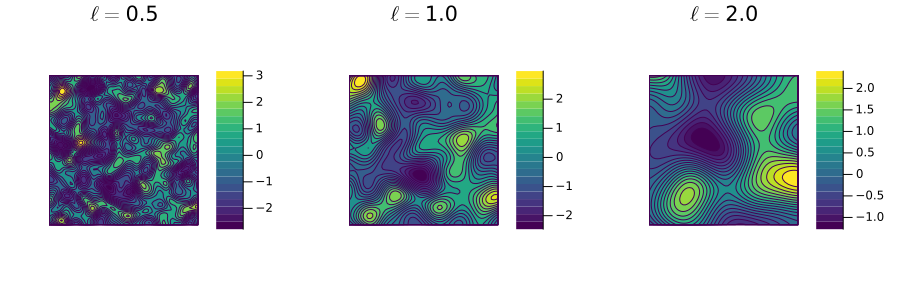

In [15]:
using Random


x_arr = range(0, stop=10, length=71)
y_arr = range(0, stop=10, length=71)

plts = []
for l in [0.5, 1.0, 2.0]

	GP = GaussianProcess(k = (x, x′) -> exp(-(norm(x - x′)^2/(2*l^2))))

	# create random "true" function
	Random.seed!(0)
	X = vec([[x, y] for x in x_arr, y in y_arr])
	z = rand(GP, X)
	n = length(x_arr)
	A = Float64[z[(i-1)*n+j] for i in 1:length(x_arr), j in 1 : length(y_arr)]


	push!(plts, Plots.contourf(x_arr, y_arr, A, colormap=:viridis, levels=20, title = L"\ell = "*string(l)))
end

plot(plts..., layout=(1, 3), aspectratio=:equal, size=(900, 300), axis=false, grid=false)

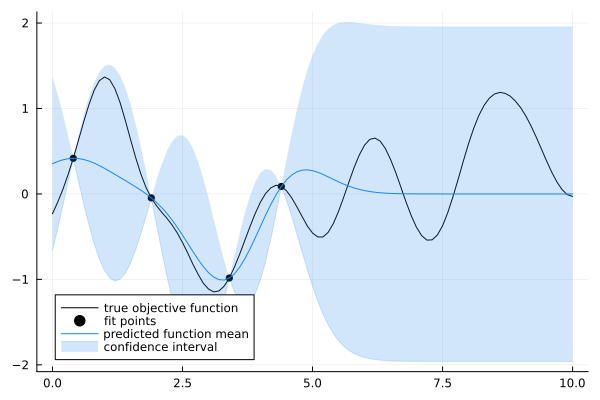

In [16]:
using Random

# create random "true" function
Random.seed!(0)
GP = GaussianProcess()
x_arr = range(0, stop=10, length=101)
X = [[x] for x in collect(x_arr)]
y = rand(GP, X)

p_true = Plots.plot(x_arr, y, label="true objective function", color=:black)

# create training set
for i in [5, 20, 35, 45]
	push!(GP, X[i], y[i])
end
p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, label="fit points", color=:black)

# predict
μₚ, νₚ = predict(GP, X)
p_pred_μ = Plots.plot!(x_arr, μₚ, label="predicted function mean", color=:dodgerblue2)
σₚ = sqrt.(νₚ)
upperConfidence = μₚ + 1.96*σₚ
lowerConfidence = μₚ - 1.96*σₚ
Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)


# Probabilistic Surrogate Optimization

# Prediction-Based Exploration

In [17]:
n = 1
N = 4
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=201)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
	push!(GP, [x], f_true(x))
end

all_plts = []

Any[]

Note: run the next cell multiple times if you want to see the sampling process step-by-step

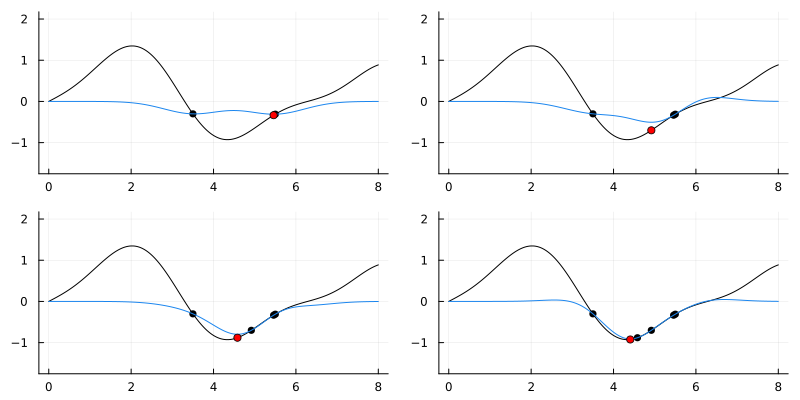

In [21]:
plot(p_true)
p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, label="fit points", color=:black)

# predict
μₚ, νₚ = predict(GP, X)
σₚ = sqrt.(νₚ)
p_pred_μ = Plots.plot!(x_arr, μₚ, label="predicted", color=:dodgerblue2)
upperConfidence = μₚ + 1.96*σₚ
lowerConfidence = μₚ - 1.96*σₚ

# prediction-based optimization
pred_μ = x -> predict(GP, Vector{Float64}[Float64[x]])[1][1]
x_slice = myopt(pred_μ)

# slice
y_dom = (-2,2)
plts = Plots.scatter!([x_slice], [f_true(x_slice)], label="next sample", color=:red)

push!(GP, [x_slice], f_true(x_slice))
push!(x_train, x_slice)
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=201)), x_train)))
X = [[x] for x in collect(x_arr)]

push!(all_plts, plts)
n += 1

plot(all_plts..., layout=(2, 2), aspectratio=:equal, size=(800, 400), legend=false)



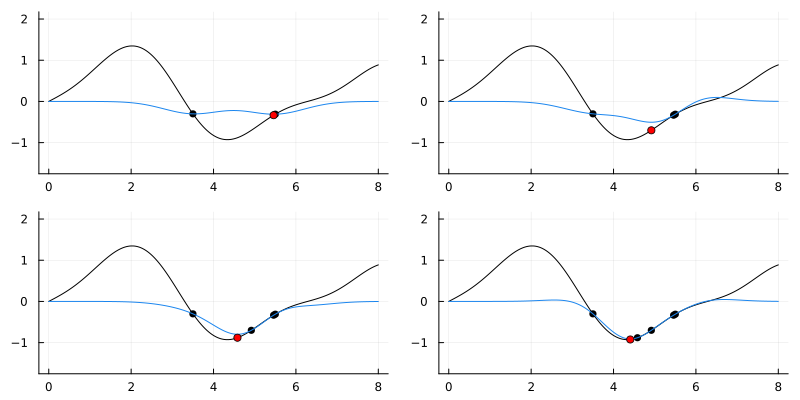

In [22]:

N = 4
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=201)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
	push!(GP, [x], f_true(x))
end

all_plts = []

for n in 1 : N
	
	plot(p_true)
	p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, label="fit points", color=:black)

	# predict
	μₚ, νₚ = predict(GP, X)
	σₚ = sqrt.(νₚ)
	p_pred_μ = Plots.plot!(x_arr, μₚ, label="predicted", color=:dodgerblue2)
	upperConfidence = μₚ + 1.96*σₚ
	lowerConfidence = μₚ - 1.96*σₚ

	# prediction-based optimization
	pred_μ = x -> predict(GP, Vector{Float64}[Float64[x]])[1][1]
	x_slice = myopt(pred_μ)

	# slice
	y_dom = (-2,2)
	plts = Plots.scatter!([x_slice], [f_true(x_slice)], label="next sample", color=:red)

	push!(GP, [x_slice], f_true(x_slice))
	push!(x_train, x_slice)
	x_arr = unique(sort!(append!(collect(range(0, stop=8, length=201)), x_train)))
	X = [[x] for x in collect(x_arr)]

    push!(all_plts, plts)
end

plot(all_plts..., layout=(2, 2), aspectratio=:equal, size=(800, 400), legend=false)

# Error-Based Exploration

In [23]:
n = 1
N = 4
M = 2
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=101)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = Plots.plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
    push!(GP, [x], f_true(x))
end

all_plts = []


Any[]

Note: run the next cell multiple times if you want to see the sampling process step-by-step

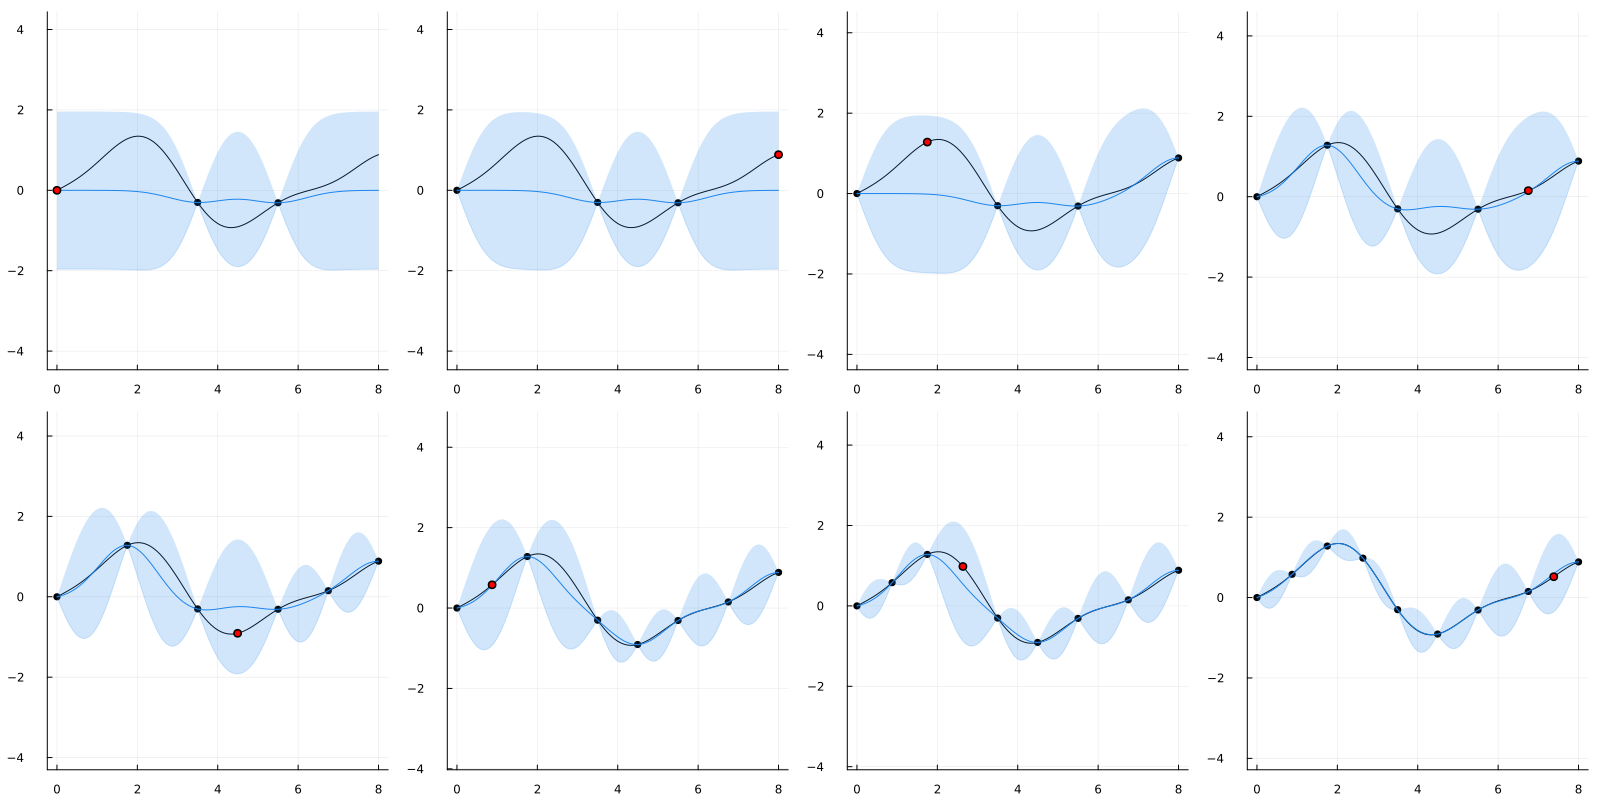

In [31]:
plot(p_true)

p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

# predict
μₚ, νₚ = predict(GP, X)
σₚ = sqrt.(νₚ)
p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
upperConfidence = μₚ + 1.96*σₚ
lowerConfidence = μₚ - 1.96*σₚ
Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)

# prediction-based optimization
pred_ν = x->predict(GP, Vector{Float64}[Float64[x]])[2][1]
x_slice = myopt(x->-pred_ν(x))

# slice
y_dom = (-2,2)
plts = Plots.scatter!([x_slice], [f_true(x_slice)], color=:red, label="sampled")


push!(GP, [x_slice], f_true(x_slice))
push!(x_train, x_slice)

i = findfirst(x_arr .> x_slice)
if min(abs(x_arr[i] - x_slice), abs(x_arr[i-1] - x_slice)) > 1e-4
    insert!(x_arr, i, x_slice)
end
X = [[x] for x in collect(x_arr)]

push!(all_plts, plts)    
n += 1

plot(all_plts..., layout=(M, N), aspectratio=:equal, size=(400*N, 400*M), legend=false)

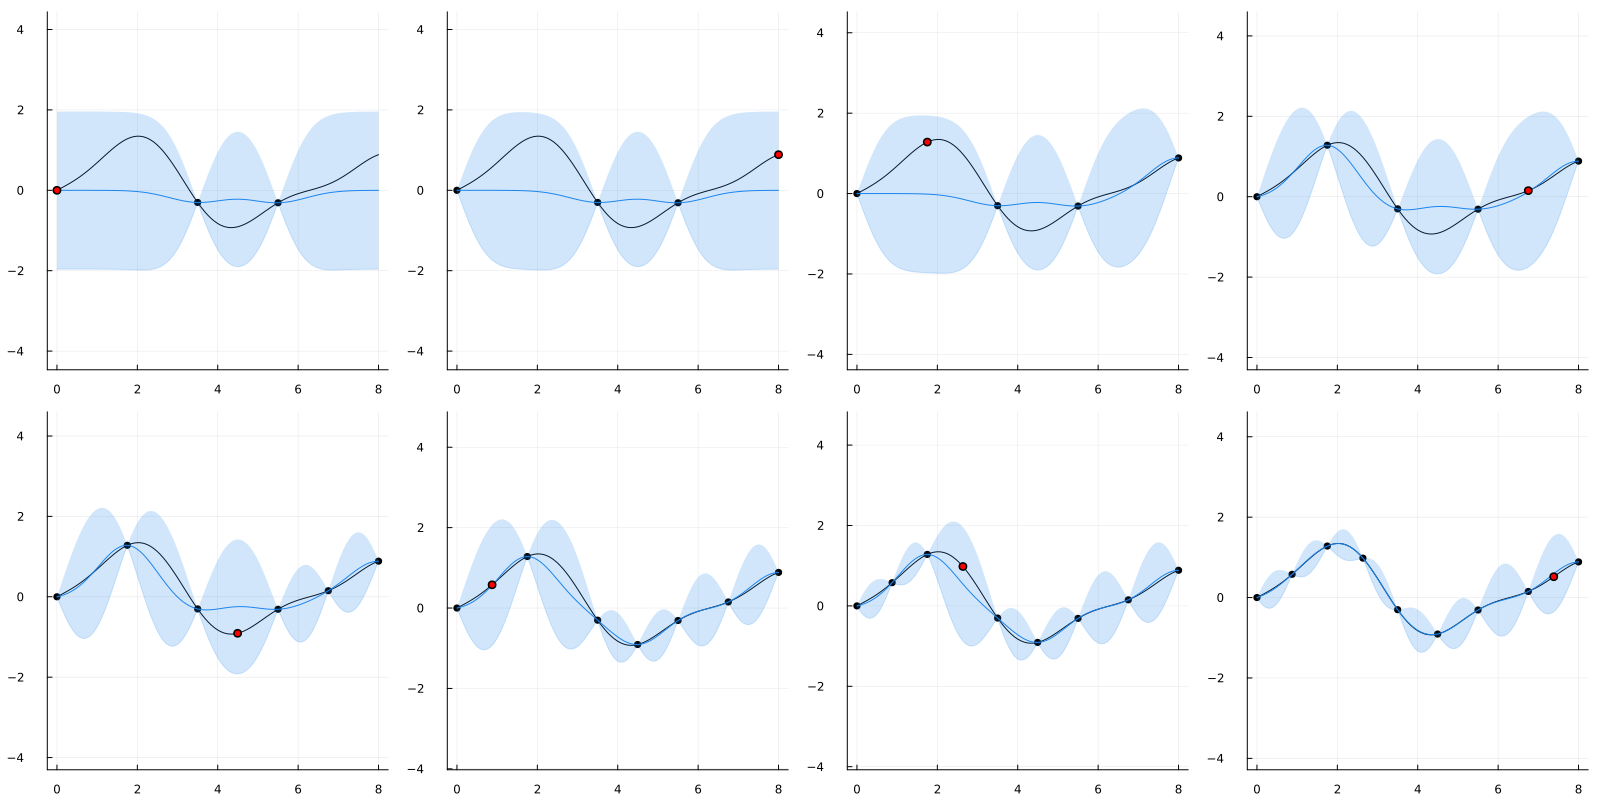

In [7]:
N = 4
M = 2
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=101)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = Plots.plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
    push!(GP, [x], f_true(x))
end

all_plts = []
for n in 1 : N*M
    plot(p_true)

    p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

    # predict
    μₚ, νₚ = predict(GP, X)
    σₚ = sqrt.(νₚ)
    p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
    upperConfidence = μₚ + 1.96*σₚ
    lowerConfidence = μₚ - 1.96*σₚ
    Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)

    # prediction-based optimization
    pred_ν = x->predict(GP, Vector{Float64}[Float64[x]])[2][1]
    x_slice = myopt(x->-pred_ν(x))

    # slice
    y_dom = (-2,2)
    plts = Plots.scatter!([x_slice], [f_true(x_slice)], color=:red, label="sampled")


    push!(GP, [x_slice], f_true(x_slice))
    push!(x_train, x_slice)

    i = findfirst(x_arr .> x_slice)
    if min(abs(x_arr[i] - x_slice), abs(x_arr[i-1] - x_slice)) > 1e-4
        insert!(x_arr, i, x_slice)
    end
    X = [[x] for x in collect(x_arr)]

    push!(all_plts, plts)    
end

plot(all_plts..., layout=(M, N), aspectratio=:equal, size=(400*N, 400*M), legend=false)

# Lower Confidence Bound Exploration

In [53]:
n = 1
N = 4
M = 2
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=101)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = Plots.plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
    push!(GP, [x], f_true(x))
end

all_plts = []


Any[]

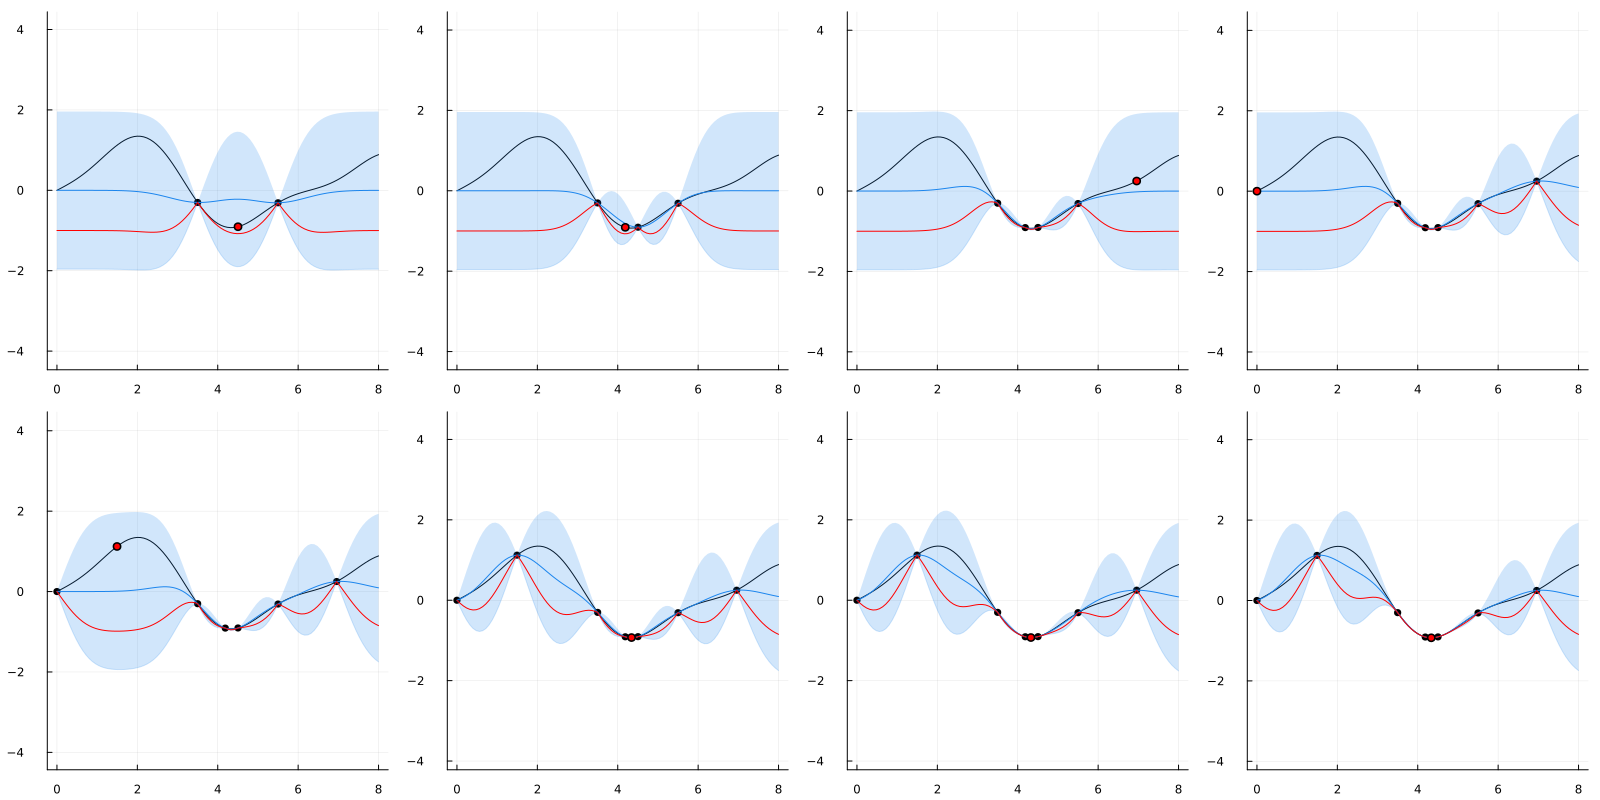

In [61]:
plot(p_true)

p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

# predict
μₚ, νₚ = predict(GP, X)
σₚ = sqrt.(νₚ)
p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
upperConfidence = μₚ + 1.96*σₚ
lowerConfidence = μₚ - 1.96*σₚ
Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)

# prediction-based optimization
pred_μ = x->predict(GP, Vector{Float64}[Float64[x]])[1][1]
pred_ν = x->predict(GP, Vector{Float64}[Float64[x]])[2][1]
f_opt = x->pred_μ(x) - sqrt(pred_ν(x))
x_slice = myopt(f_opt)
p_opt = Plots.plot!(x_arr, f_opt.(x_arr), color=:red, label="lower bound")


# slice
y_dom = (-2,2)
plts = Plots.scatter!([x_slice], [f_true(x_slice)], color=:red, label="sampled")


push!(GP, [x_slice], f_true(x_slice))
push!(x_train, x_slice)

i = findfirst(x_arr .> x_slice)
if min(abs(x_arr[i] - x_slice), abs(x_arr[i-1] - x_slice)) > 1e-4
    insert!(x_arr, i, x_slice)
end
X = [[x] for x in collect(x_arr)]

push!(all_plts, plts)    
n+=1

plot(all_plts..., layout=(M, N), aspectratio=:equal, size=(400*N, 400*M), legend=false)

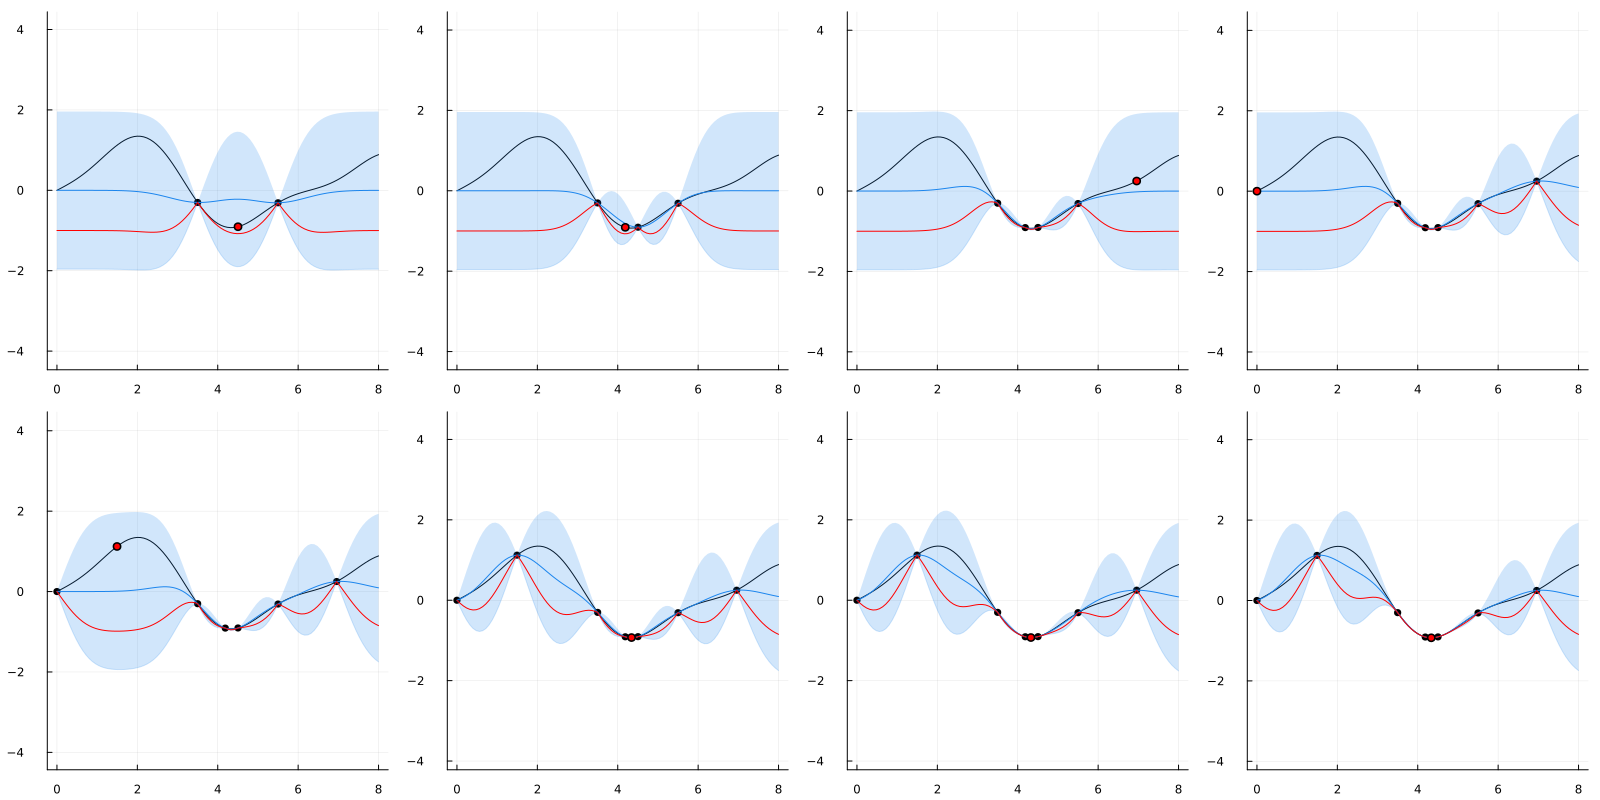

In [8]:
N = 4
M = 2
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=101)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = Plots.plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
    push!(GP, [x], f_true(x))
end

all_plts = []
for n in 1 : N*M
    plot(p_true)

    p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

    # predict
    μₚ, νₚ = predict(GP, X)
    σₚ = sqrt.(νₚ)
    p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
    upperConfidence = μₚ + 1.96*σₚ
    lowerConfidence = μₚ - 1.96*σₚ
    Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)

    # prediction-based optimization
    pred_μ = x->predict(GP, Vector{Float64}[Float64[x]])[1][1]
    pred_ν = x->predict(GP, Vector{Float64}[Float64[x]])[2][1]
    f_opt = x->pred_μ(x) - sqrt(pred_ν(x))
    x_slice = myopt(f_opt)
    p_opt = Plots.plot!(x_arr, f_opt.(x_arr), color=:red, label="lower bound")


    # slice
    y_dom = (-2,2)
    plts = Plots.scatter!([x_slice], [f_true(x_slice)], color=:red, label="sampled")


    push!(GP, [x_slice], f_true(x_slice))
    push!(x_train, x_slice)

    i = findfirst(x_arr .> x_slice)
    if min(abs(x_arr[i] - x_slice), abs(x_arr[i-1] - x_slice)) > 1e-4
        insert!(x_arr, i, x_slice)
    end
    X = [[x] for x in collect(x_arr)]

    push!(all_plts, plts)    
end

plot(all_plts..., layout=(M, N), aspectratio=:equal, size=(400*N, 400*M), legend=false)

# Probability of Improvement

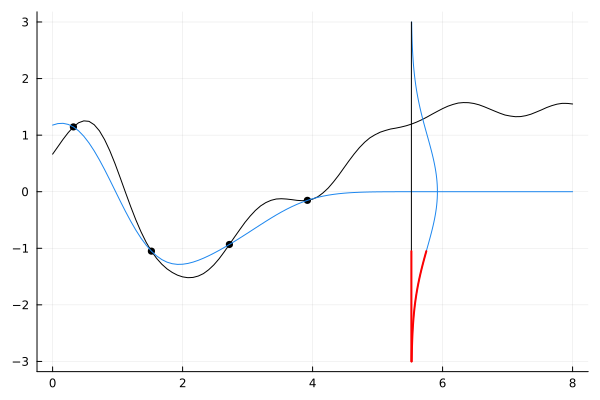

In [9]:
GP = GaussianProcess()

# create random "true" function
Random.seed!(3)
x_arr = range(0, stop=8, length=101)
X = [[x] for x in collect(x_arr)]
y = rand(GP, X)

p_true = Plots.plot(x_arr, y, color=:black, label="true")

# create training set
for i in [5, 20, 35, 50]
    push!(GP, X[i], y[i])
end
p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

# predict
μₚ, νₚ = predict(GP, X)
σₚ = sqrt.(νₚ)
p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
upperConfidence = μₚ + 1.96*σₚ
lowerConfidence = μₚ - 1.96*σₚ

# slice
slice_index = 70
y_dom = (-3,3)
x_slice = X[slice_index][1]
μ_slice = μₚ[slice_index]
σ_slice = σₚ[slice_index]
N = Normal(μ_slice, σ_slice)
y_arr = collect(range(y_dom[1], stop=y_dom[2], length=101))
x_arr = [x_slice + pdf(N, y) for y in y_arr]
p_slice = Plots.plot!(x_arr, y_arr, color=:dodgerblue2)
p_slice_vert = Plots.plot!([x_slice, x_slice], [y_arr[1], y_arr[end]], color=:black)

y_min = minimum(GP.y)
x_min = GP.X[argmin(GP.y)][1]
p_fill_lo = Plots.plot!([x_slice, x_slice], [y_arr[1], y_min], color=:red, linewidth=2)
y_arr_hi = collect(range(y_dom[1], stop=y_min, length=51))
x_arr_hi = [x_slice + pdf(N, y) for y in y_arr_hi]
p_fill_hi = Plots.plot!(x_arr_hi, y_arr_hi, color=:red, linewidth=2, legend=false)


# Probability of Improvement Exploration

In [62]:
prob_of_improvement(y_min, μ, ν) = isapprox(ν, 0, atol=1e-4) ? 0.0 : cdf(Normal(μ, sqrt(ν)), y_min)

prob_of_improvement (generic function with 2 methods)

In [84]:
n = 1
N = 4
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=101)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = Plots.plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
    push!(GP, [x], f_true(x))
end

all_plts = []


Any[]

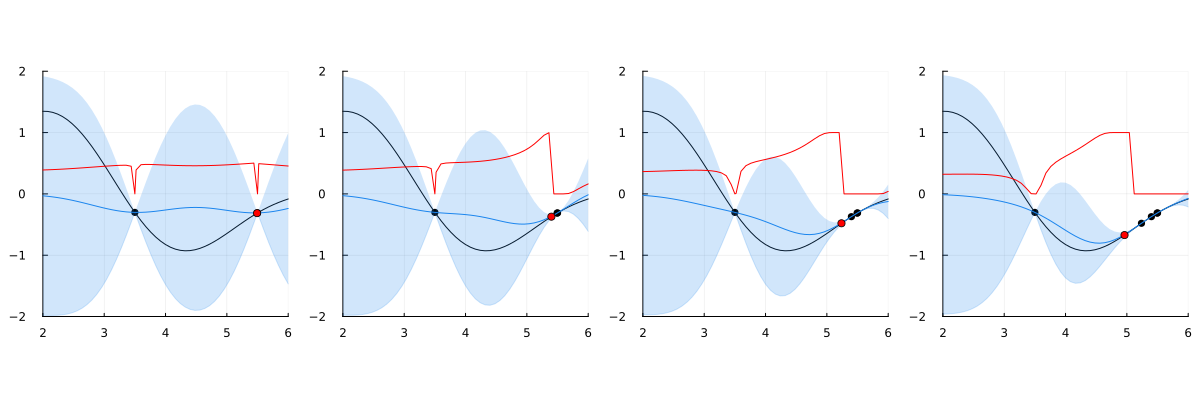

In [88]:
plot(p_true)

p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

# predict
μₚ, νₚ = predict(GP, X)
σₚ = sqrt.(νₚ)
p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
upperConfidence = μₚ + 1.96*σₚ
lowerConfidence = μₚ - 1.96*σₚ
Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)

# prediction-based optimization
# prediction-based optimization
pred_μ = x->predict(GP, Vector{Float64}[Float64[x]])[1][1]
pred_ν = x->predict(GP, Vector{Float64}[Float64[x]])[2][1]
y_min = minimum(GP.y)
f_opt = x->prob_of_improvement(y_min, pred_μ(x), pred_ν(x))
x_slice = myopt(x->-f_opt(x))
p_opt = Plots.plot!(x_arr, f_opt.(x_arr), color=:red)
# p_opt_vert = Plots.plot!([x_slice, x_slice], [f_opt(x_slice), f_true(x_slice)], color=:red)

# slice
y_dom = (-2,2)
plts = Plots.scatter!([x_slice], [f_true(x_slice)], color=:red, label="sampled", xlims=(2,6), ylims=y_dom)


push!(GP, [x_slice], f_true(x_slice))
push!(x_train, x_slice)

i = findfirst(x_arr .> x_slice)
if min(abs(x_arr[i] - x_slice), abs(x_arr[i-1] - x_slice)) > 1e-4
    insert!(x_arr, i, x_slice)
end
X = [[x] for x in collect(x_arr)]

push!(all_plts, plts)    
n += 1

plot(all_plts..., layout=(1, 4), aspectratio=:equal, size=(1200, 400), legend=false)

In [ ]:
prob_of_improvement(y_min, μ, ν) = isapprox(ν, 0, atol=1e-4) ? 0.0 : cdf(Normal(μ, sqrt(ν)), y_min)
N = 4
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=101)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = Plots.plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
    push!(GP, [x], f_true(x))
end

all_plts = []
for n in 1 : N
    plot(p_true)

    p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

    # predict
    μₚ, νₚ = predict(GP, X)
    σₚ = sqrt.(νₚ)
    p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
    upperConfidence = μₚ + 1.96*σₚ
    lowerConfidence = μₚ - 1.96*σₚ
    Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)

    # prediction-based optimization
    # prediction-based optimization
    pred_μ = x->predict(GP, Vector{Float64}[Float64[x]])[1][1]
    pred_ν = x->predict(GP, Vector{Float64}[Float64[x]])[2][1]
    y_min = minimum(GP.y)
    f_opt = x->prob_of_improvement(y_min, pred_μ(x), pred_ν(x))
    x_slice = myopt(x->-f_opt(x))
    p_opt = Plots.plot!(x_arr, f_opt.(x_arr), color=:red)
    # p_opt_vert = Plots.plot!([x_slice, x_slice], [f_opt(x_slice), f_true(x_slice)], color=:red)

    # slice
    y_dom = (-2,2)
    plts = Plots.scatter!([x_slice], [f_true(x_slice)], color=:red, label="sampled", xlims=(2,6), ylims=y_dom)


    push!(GP, [x_slice], f_true(x_slice))
    push!(x_train, x_slice)

    i = findfirst(x_arr .> x_slice)
    if min(abs(x_arr[i] - x_slice), abs(x_arr[i-1] - x_slice)) > 1e-4
        insert!(x_arr, i, x_slice)
    end
    X = [[x] for x in collect(x_arr)]

    push!(all_plts, plts)    
end

plot(all_plts..., layout=(1, 4), aspectratio=:equal, size=(1200, 400), legend=false)

# Expected Improvement

In [69]:
function expected_improvement(y_min, μ, ν)
	if isapprox(ν, 0.0, atol=1e-4)
		return 0.0
	end
	σ = sqrt(ν)
    tmp = (y_min - μ)/σ
    p_imp = prob_of_improvement(y_min, μ, ν)
    p_ymin = pdf(Normal(μ, σ), y_min)
    return (y_min - μ)*p_imp + σ^2*p_ymin
end

expected_improvement (generic function with 1 method)

In [70]:
n = 1
N = 4
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=101)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = Plots.plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
    push!(GP, [x], f_true(x))
end

all_plts = []

Any[]

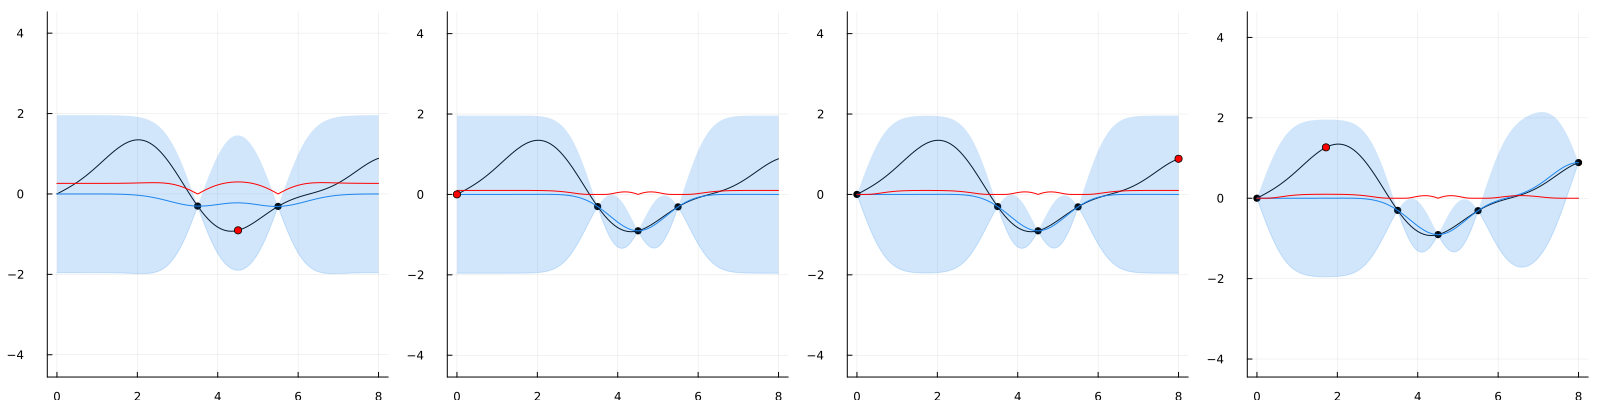

In [74]:
plot(p_true)

p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

# predict
μₚ, νₚ = predict(GP, X)
σₚ = sqrt.(νₚ)
p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
upperConfidence = μₚ + 1.96*σₚ
lowerConfidence = μₚ - 1.96*σₚ
Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)

# prediction-based optimization
pred_μ = x->predict(GP, Vector{Float64}[Float64[x]])[1][1]
pred_ν = x->predict(GP, Vector{Float64}[Float64[x]])[2][1]
y_min = minimum(GP.y)
f_opt = x->expected_improvement(y_min, pred_μ(x), pred_ν(x) + 1e-8)
x_slice = myopt(x->-f_opt(x))
p_opt = Plots.plot!(x_arr, f_opt.(x_arr), color=:red)

# slice
y_dom = (-2,2)
plts = Plots.scatter!([x_slice], [f_true(x_slice)], color=:red, label="sampled")

push!(GP, [x_slice], f_true(x_slice))
push!(x_train, x_slice)
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=201)), x_train)))
X = [[x] for x in collect(x_arr)]


push!(all_plts, plts)    
n += 1

plot(all_plts..., layout=(1, 4), aspectratio=:equal, size=(1600, 400), legend=false)

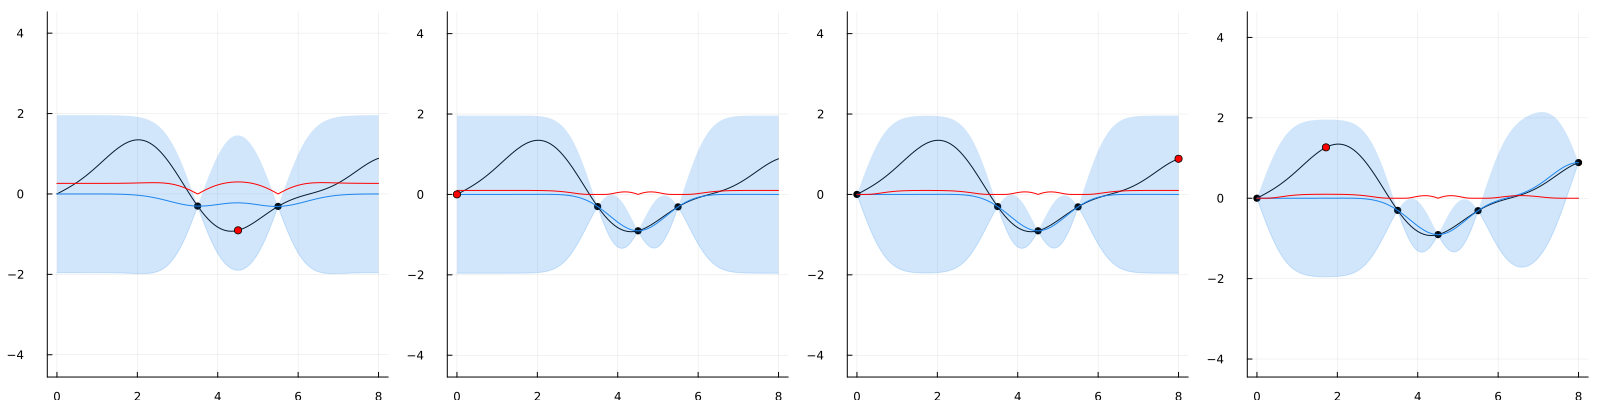

In [11]:

function expected_improvement(y_min, μ, ν)
	if isapprox(ν, 0.0, atol=1e-4)
		return 0.0
	end
	σ = sqrt(ν)
    tmp = (y_min - μ)/σ
    p_imp = prob_of_improvement(y_min, μ, ν)
    p_ymin = pdf(Normal(μ, σ), y_min)
    return (y_min - μ)*p_imp + σ^2*p_ymin
end

N = 4
y_dom = (-2,2)

f_true = x -> sin(x) + 0.25*sin(x/2) - 0.3*sin(2x)
x_train = [3.5, 5.5]
x_arr = unique(sort!(append!(collect(range(0, stop=8, length=101)), x_train)))
X = [[x] for x in collect(x_arr)]
y = (x -> f_true(x[1])).(X)

p_true = Plots.plot(x_arr, y, label="true", color=:black)

# create training set
GP = GaussianProcess()
for x in x_train
    push!(GP, [x], f_true(x))
end

all_plts = []

for n in 1 : N
    plot(p_true)

    p_train = Plots.scatter!([x[1] for x in GP.X], GP.y, color=:black, label="fit points")

    # predict
    μₚ, νₚ = predict(GP, X)
    σₚ = sqrt.(νₚ)
    p_pred_μ = Plots.plot!(x_arr, μₚ, color=:dodgerblue2, label="predicted")
    upperConfidence = μₚ + 1.96*σₚ
    lowerConfidence = μₚ - 1.96*σₚ
    Plots.plot!(x_arr, lowerConfidence, fillrange=upperConfidence, alpha=0.2, label="confidence interval", color=:dodgerblue2)

    # prediction-based optimization
    pred_μ = x->predict(GP, Vector{Float64}[Float64[x]])[1][1]
    pred_ν = x->predict(GP, Vector{Float64}[Float64[x]])[2][1]
    y_min = minimum(GP.y)
    f_opt = x->expected_improvement(y_min, pred_μ(x), pred_ν(x) + 1e-8)
    x_slice = myopt(x->-f_opt(x))
    p_opt = Plots.plot!(x_arr, f_opt.(x_arr), color=:red)

    # slice
    y_dom = (-2,2)
    plts = Plots.scatter!([x_slice], [f_true(x_slice)], color=:red, label="sampled")

    push!(GP, [x_slice], f_true(x_slice))
    push!(x_train, x_slice)
    x_arr = unique(sort!(append!(collect(range(0, stop=8, length=201)), x_train)))
    X = [[x] for x in collect(x_arr)]


    push!(all_plts, plts)    
end

plot(all_plts..., layout=(1, 4), aspectratio=:equal, size=(1600, 400), legend=false)

This code defines a function called `myopt` which you'll find in "gp.jl" that finds the approximate minimum value of a given function `f` within a specified range [a, b] using a simple optimization technique. The function accepts the following arguments:

1. f: a single-variable function to be optimized.
2. a: the start of the interval on which to search for the minimum. Default value is 0.0.
3. b: the end of the interval on which to search for the minimum. Default value is 8.0.
4. Δx: the size of the sub-intervals for searching. Default value is 0.1.

Step-by-step:

1. Initialize the `best_x` and `best_y` variables to store the optimal input value (minimizer) and output value (minimum) of the function `f`.

2. Calculate the number of sub-intervals `m` by dividing the total interval (b-a) by Δx and rounding up to the nearest integer.

3. Create a range of points `pts` from `a` to `b` with `m+1` elements, dividing the interval into `m` sub-intervals.

4. Iterate through the sub-intervals using a for loop, and perform the following steps:

   a. Optimize the function `f` within the current sub-interval `[pts[i], pts[i+1]]` using the `optimize` function. This function returns an object containing the minimum value of `f` and its corresponding input value (minimizer) within the current sub-interval.
   
   b. Check if the minimum value found in the current sub-interval is smaller than the previously recorded best minimum value `best_y`. If so, update `best_y` with the new minimum value and `best_x` with the corresponding minimizer.

5. After iterating through all the sub-intervals, return the best minimizer (`best_x`) found.

In [ ]:
function myopt(f; a=0.0, b=8.0, Δx=0.1)
    best_x = a
    best_y = Inf
    m = ceil(Int, (b-a)/Δx)
    pts = range(a, stop=b, length=m+1)
    for i in 1 : m
        res = optimize(f, pts[i], pts[i+1])
        if res.minimum < best_y
            best_y = res.minimum
            best_x = res.minimizer
        end
    end
    return best_x
end